<a href="https://colab.research.google.com/github/chottokun/Janome_NElogd/blob/main/colab_notebooks/large_language_mario_chotto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Large Language Mario

LLMを使ってマリオをプレイするチャレンジ

## 必要なライブラリのインストールとインポート
AIマリオに必要なライブラリのインストールとインポートを行います。

[OpenAI Gymのマリオ用パッケージ](https://github.com/Kautenja/gym-super-mario-bros)をインストールします。強化学習の環境として使用します。詳細の仕様は[GitHub](https://github.com/Kautenja/gym-super-mario-bros)参照ください。


In [ ]:
!pip install -qqq gym-super-mario-bros==7.3.0

その他、必要なライブラリをインストールします。

In [ ]:
!apt -qq update
!apt install -y -qq xvfb
!pip install -qqq pyvirtualdisplay

49 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


必要なライブラリをインポートします。

In [ ]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym.spaces import Box
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
from gym_super_mario_bros.actions import RIGHT_ONLY

import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2
from PIL import Image
import requests

import os
from google.colab import userdata
import base64
import json

## AIマリオ環境の構築

AIマリオの環境構築を行います。



### AIマリオ環境初期化と動作確認
環境の確認です。

In [ ]:
STAGE_NAME = 'SuperMarioBros-1-1-v0'

In [ ]:
# マリオ1-1の環境を初期化します。
env = gym_super_mario_bros.make(STAGE_NAME)

# マリオの行動空間を設定します。
env = JoypadSpace(env, SIMPLE_MOVEMENT)

# MOVEMENT = [["right"], ["right", "A"]]
# env = JoypadSpace(env, MOVEMENT)
# env = JoypadSpace(env, COMPLEX_MOVEMENT)
# env = JoypadSpace(env, RIGHT_ONLY)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


ステージの初期化と行動空間の設定をしています。

PyTorchチュートリアルでは、以下のように2パターンに単純化した行動をするマリオに制限されています。

```
# 行動空間を以下に制限
#   0. 右に歩く
#   1. 右方向にジャンプ
env = JoypadSpace(env, [["right"], ["right", "A"]])
```

自分で自由に設定する他、`gym_super_mario_bros`では`SIMPLE_MOVEMENT`, `COMPLEX_MOVEMENT`といった複数のパターンが登録されています。どのようなパターンがあるかは、[gym_super_mario_brosのソースコード](https://github.com/Kautenja/gym-super-mario-bros/blob/master/gym_super_mario_bros/actions.py)を読むか、以下のように中身を`print`して確認する方法があります。

L今回は`SIMPLE_MOVEMENT`を採用しています。

In [ ]:
print(SIMPLE_MOVEMENT)
print(COMPLEX_MOVEMENT)

[['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']]
[['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left'], ['left', 'A'], ['left', 'B'], ['left', 'A', 'B'], ['down'], ['up']]


環境をリセットして、環境を確認します。

`env.step(action=0)`と、エージェント（マリオ）がアクションすると、環境から状態(`state`)と報酬(`reward`)、終了したかのフラグ(`done`)、情報(`info`)が返ってきます。

In [ ]:
env.reset()
state, reward, done, info = env.step(action=0)

print('state:', state.shape)
print('reward:', reward)
print('done:', done)
print('info:', info)

state: (240, 256, 3)
reward: 0.0
done: False
info: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


行動`action`の範囲や状態`state`の範囲を確認したい場合は、以下を実行してください。

```python
from gym.spaces import Box, Discrete
def print_spaces(space):
    print(space)

    if isinstance(space, Box):
        print('min:', space.low)
        print('max:', space.high)
    if isinstance(space, Discrete):
        print('min:', 0)
        print('max:', space.n-1)

print('action space------------------')
print_spaces(env.action_space)
print('observation space------------------')
print_spaces(env.observation_space)
```

最後に`state`を画像として可視化してみます。

マリオのプレイ画面であることを確認できます。

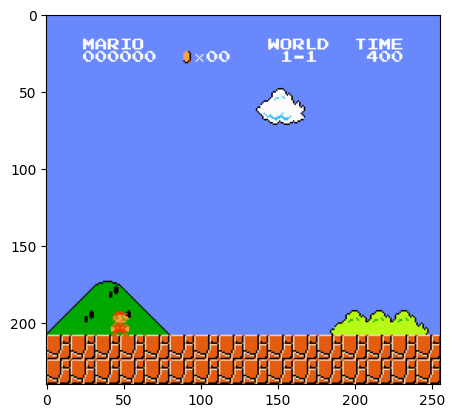

In [ ]:
plt.imshow(state)

`state`は`numpy.ndarray'です。

In [ ]:
print(type(state))

<class 'numpy.ndarray'>


`state`を画像に変換します。

In [ ]:
image = Image.fromarray(state)
image.save('state.png')

画像も表示を確認します

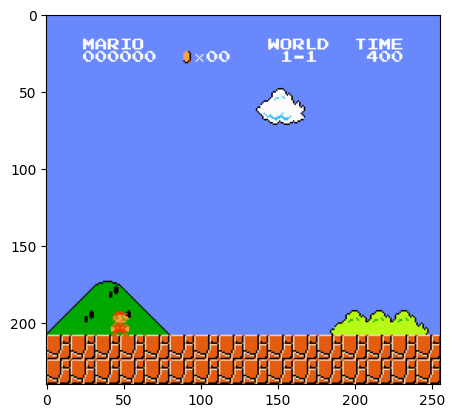

In [ ]:
img = Image.open('state.png')
imshow(img)

## LLMのテスト

LLMが正しく画像を読み込んでプレイできるかテストします。
OpenAIのライブラリをインストールします。

In [ ]:
!pip install -qqq openai

OpenAI API KEYを読み込みます。

あらかじめ、Google Colabのシークレットキーとして`OPENAI_API_KEY`を設定しておいてください。シークレットキーの設定方法は以下記事など参考にしてください。


[Google Colab のシークレット機能の使い方](https://note.com/npaka/n/n79bb63e17685)

LLMで画像を読み込めるようにエンコードする関数を定義します。

In [ ]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

画像からマリオの動きを推論する関数を定義します。

In [ ]:
def predict(state, explanation="", reason="", action=0):
    # 今のマリオの状態をPNG画像として保存
    image = Image.fromarray(state)
    image.save('state.png')

    # 画像ファイルをエンコーディング
    image_path = "./state.png"
    base64_image = encode_image(image_path)

    api_key = userdata.get("OPENAI_API_KEY")

    if reason != "":
        current_state = f"""
        # 前回の操作
        explanation: {explanation}
        reason: {reason}
        action: {action}
        """
    else:
        current_state  = ""

    # プロンプト
    prompt = f"""
        あなたは高度なテクニックをもったゲームプレイヤーです。
        画像はゲーム、スーパーマリオのプレイ画面です。
        画像の状況を見極め、行動決定フローに従って、ボタン操作を以下の7つからどれかを選んでください。
        NOOPが操作しない。'A'がジャンプ。Bがダッシュです。早く高得点でゴールを達成します。

        0 = 'NOOP'
        1 = 'right'
        2 = 'right', 'A'
        3 = 'right', 'B'
        4 = 'right', 'A', 'B'
        5 = 'A'
        6 = 'left'
        {current_state}

        # 行動決定フロー
        Step.1 前回のexplanation,reason,actionを参考に、マリオを中心とした周囲の状況を解析
        Step.2 障害物・敵とマリオの距離を「短・中・長」で評価
        Step.3 距離に応じて行動を決定。短・中・長で最適な行動が異なる。
        Step.4 決定した行動の結果を予測。敵への接触がある場合は、Step.2に戻る
        Step.5 最終的な行動を決定。

        # ゲームのポイント
        - 'A'を選択しジャンプする前には一度'A'を必ず選択から外す。前回の操作に'A'がある場合はそれ以外を選択する。
        - ダッシュジャンプ(3)と通常のジャンプ(2)を使い分ける
        - 中ジャンプ：4 ダッシュしてジャンプする。高い障害物に有利
        - 大ジャンプ：3→4 障害物から離れてダッシュしてジャンプする。より高い障害物や落下対策に有利

        以下の通りjson出力してください。日本語でお願いします。あなたの行動がマリオの運命を決めます。

    　　explanation: 画面の説明
        reason: ボタン操作の理由
        action: ボタン操作の種類
    """

    headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
    }

    payload = {
    "model": "gpt-4o-2024-08-06",
    "messages": [
        {
        "role": "user",
        "content": [
            {
            "type": "text",
            "text": f"{prompt}"
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
            }
            }
        ]
        }
    ],
    "max_tokens": 300,
    "temperature": 1,
    "response_format": {
        "type": "json_schema",
        "json_schema": {
        "name": "mario_action",
        "description": "Mario's action",
        "schema": {
            "type": "object",
            "properties": {
            "explanation": {
                "type": "string",
                "description": "画面の説明",
            },
            "reason": {
                "type": "string",
                "description": "ボタン操作の理由",
            },
            "action": {
                "type": "integer",
                "description": "ボタン操作の種類",
                "enum": [0, 1, 2, 3, 4, 5, 6],
                "enumNames": ["NOOP", "right", "right, A", "right, B", "right, A, B", "A", "left"]
            }
            },
            "required": ["explanation", "reason", "action"],
        }
        }
    }
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

    content_dict = json.loads(response.json().get('choices')[0].get('message').get('content'))

    action = content_dict.get('action')
    explanation = content_dict.get('explanation')
    reason = content_dict.get('reason')

    if action == None:
        action = 0


    return action, explanation, reason

推論する関数をテストします。

In [ ]:
action, explanation, reason = predict(state)

アクションを確認します。右に進む（`1`）かダッシュして右に進む（`2`）になっていることを確認します。

In [ ]:
action

1

マリオの状況判断（画像の説明）を確認します

In [ ]:
explanation

'マリオはスタート地点におり、目前に障害物や敵が見えない。'

行動の理由を確認します

In [ ]:
reason

'現在、障害物や敵が存在しないため、移動を開始する。'

## AIマリオのテスト

AIモデルをテストします。

テスト回数等を設定します。

In [ ]:
EPISODE_NUMBERS = 1
MAX_TIMESTEP_TEST = 1000
SKIP_RATE = 10

In [ ]:
import copy

total_reward = [0] * EPISODE_NUMBERS
total_time = [0] * EPISODE_NUMBERS
best_reward = 0
frames_best = []
reason = ""
action = 0


for i in range(EPISODE_NUMBERS):
    state = env.reset()  # reset for each new trial
    done = False
    total_reward[i] = 0.0
    total_time[i] = 0
    skip_numb = SKIP_RATE
    frames = []

    while not done and total_time[i] < MAX_TIMESTEP_TEST:
        if skip_numb < SKIP_RATE:
            skip_numb += 1
        else:
            skip_numb = 0
            action, explanation, reason = predict(state, explanation, reason, action)

            plt.imshow(state)
            plt.pause(0.001)

            print(f'action: {action}')
            print(f'explanation: {explanation}')
            print(f'reason: {reason}')

        state, reward, done, info = env.step(action)
        total_reward[i] += reward
        total_time[i] += 1
        frames.append(copy.deepcopy(env.render(mode = 'rgb_array')))

    if total_reward[i] > best_reward:
        best_reward = total_reward[i]
        frames_best = copy.deepcopy(frames)

    print('test episode:', i, 'reward:', total_reward[i], 'time:', total_time[i])

    # Judgement Mario goal or not
    if info['flag_get']:
        print(f"<<< Mario get the flag. GOOOOOOOOOOOOOOOOOOOOOAL! >>>")
        break

print('average reward:', (sum(total_reward) / EPISODE_NUMBERS),
      'average time:', (sum(total_time) / EPISODE_NUMBERS),
      'best_reward:', best_reward)

`<<< Mario get the flag. GOOOOOOOOOOOOOOOOOOOOOAL! >>>`という表示ができたらクリアできています。

クリアできない場合は、複数回プレイして一番良いプレイ動画が保存されます。

実行のたびに結果は変わります。何回か試してみましょう。

## AIマリオのプレイ動画を保存・再生

保存した画像ログから動画を保存・再生します。

画像が多いと動画生成や確認に時間がかかるため、画像を間引きます。

画像を間引く割合を入力します（大きいほどたくさん間引きます）。

In [ ]:
SKIP_RATE = 4

画像を間引く処理をします。

In [ ]:
if SKIP_RATE == 1:
  frames_new = np.array(frames_best)
else:
  np_frames = np.array(frames_best)
  frames_new = np_frames[::SKIP_RATE].tolist()

Google Colab上で確認できる動画を生成します。生成後に再生ボタンを押すと、AIマリオのプレイ動画が見れます。

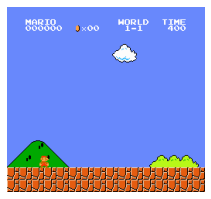

In [ ]:
import matplotlib.animation
from IPython.display import HTML

matplotlib.rcParams['animation.embed_limit'] = 2**128
plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames_new[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames_new[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames_new), interval = 50)
HTML(ani.to_jshtml())

動画形式で保存します。

In [ ]:
ani.save('ai_mario.mp4')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


動画ファイルをダウンロードします。

In [ ]:
from google.colab import files
files.download('ai_mario.mp4')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GIFアニメ形式で保存します。

In [ ]:
import imageio
imageio.mimsave('ai_mario.gif', [np.array(img) for i, img in enumerate(frames_best) if i%SKIP_RATE == 0], fps=15)

/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


GIFアニメをダウンロードします。

In [ ]:
from google.colab import files
files.download('ai_mario.gif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## リファレンス

- https://platform.openai.com/docs/guides/vision
- https://platform.openai.com/docs/guides/structured-outputs/introduction
- https://openai.com/index/introducing-structured-outputs-in-the-api/
- https://qiita.com/DEmodoriGatsuO/items/4c4734b78973970e0d3d
- https://platform.openai.com/settings/organization/billing/overview